# ACTPol + SPT-3G combined fit

## Preamble

This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np

Print versions used



In [2]:
import getdist
import matplotlib

getdist.chains.print_load_details = False

print("     Numpy :", np.__version__)
print("Matplotlib :", matplotlib.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.20.2
Matplotlib : 3.4.1
   GetDist : 1.1.4


## Definitions

Define CMB & nuisance parameter names.



In [3]:
cosmo_params = ["cosmomc_theta", "logA", "ns", "ombh2", "omch2", "H0", "tau"]

Define SPT nuisance parameters

In [4]:
spt3g_params = [
    "kappa",
    "Dl_Poisson_90x90",
    "Dl_Poisson_90x150",
    "Dl_Poisson_90x220",
    "Dl_Poisson_150x150",
    "Dl_Poisson_150x220",
    "Dl_Poisson_220x220",
    "ADust_TE_150",
    "AlphaDust_TE",
    "ADust_EE_150",
    "AlphaDust_EE",
    "mapTcal90",
    "mapTcal150",
    "mapTcal220",
    "mapPcal90",
    "mapPcal150",
    "mapPcal220",
]

Set a dictionnary holding the path to the MCMC chains and its name

In [5]:
mcmc_samples = {
    "Planck 2018 - lowl TE + TT+TE+EE": "data/planck+lowl/default/tt_te_ee",
    "ACTPol": "data/actpol/act_tau_prior",
    "SPT-3G": "data/spt3g/default/te_ee",
    "SPTPol": "data/sptpol/default/te_ee",
    "ACTPol + SPT-3G": "data/actpol+spt3g",

    "ACTPol - Neff": "data/actpol/neff",
    "SPT-3G - Neff": "data/spt3g/neff",
    "ACTPol + SPT-3G - Neff": "data/actpol+spt3g/neff",

    "ACTPol - nrun": "data/actpol/nrun",
    "SPT-3G - nrun": "data/spt3g/nrun",
    "ACTPol + SPT-3G - nrun": "data/actpol+spt3g/nrun",
}

## MCMC chains

Let's plot the chains size

In [6]:
from cobaya_utilities.tools import print_chains_size

print_chains_size(mcmc_samples)

,mcmc 1,mcmc 2,mcmc 3,mcmc 4,total
Planck 2018 - lowl TE + TT+TE+EE,50121,20721,20721,15681,107244
ACTPol,33739,25921,30481,24361,114502
SPT-3G,111462,113006,111189,114629,450286
SPTPol,65960,44760,69315,40856,220891
ACTPol + SPT-3G,48718,44259,43173,41502,177652
ACTPol - Neff,20070,15726,13463,22635,71894
SPT-3G - Neff,60189,60293,62709,57600,240791
ACTPol + SPT-3G - Neff,39644,53104,62662,55715,211125
ACTPol - nrun,14186,16763,20070,20696,71715
SPT-3G - nrun,42099,41653,36339,40032,160123


Have a look at how chains evolve with time and check convergence or not.



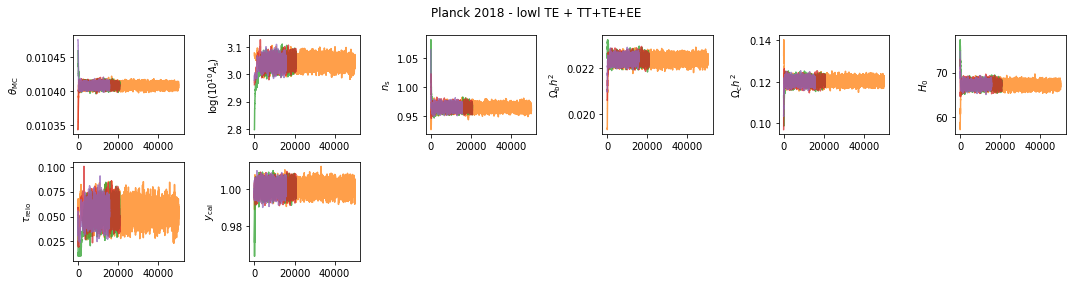

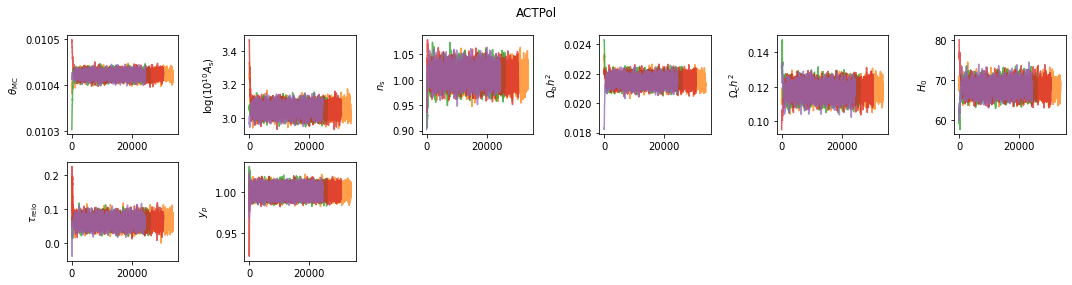

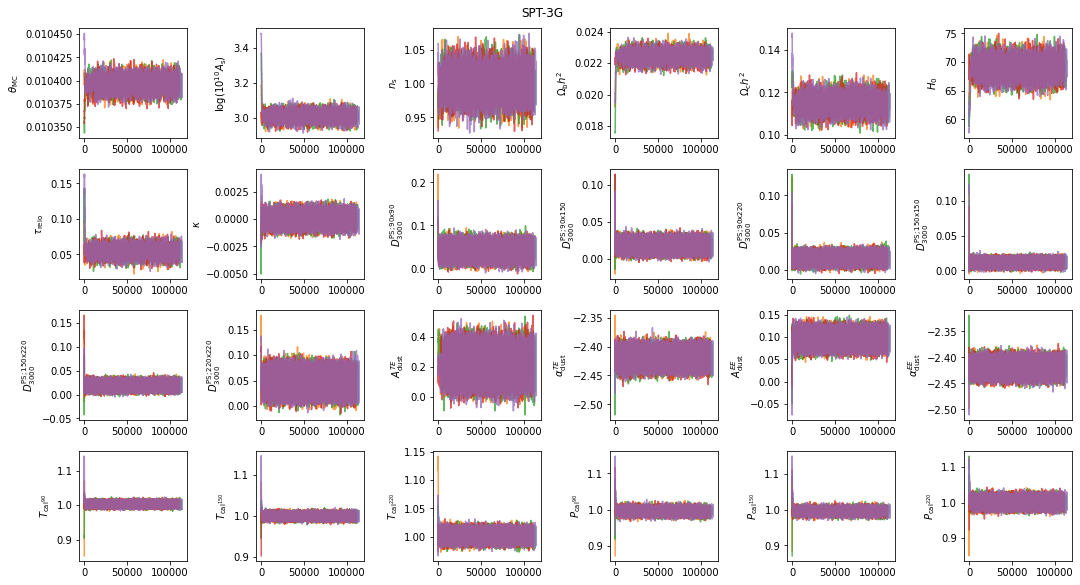

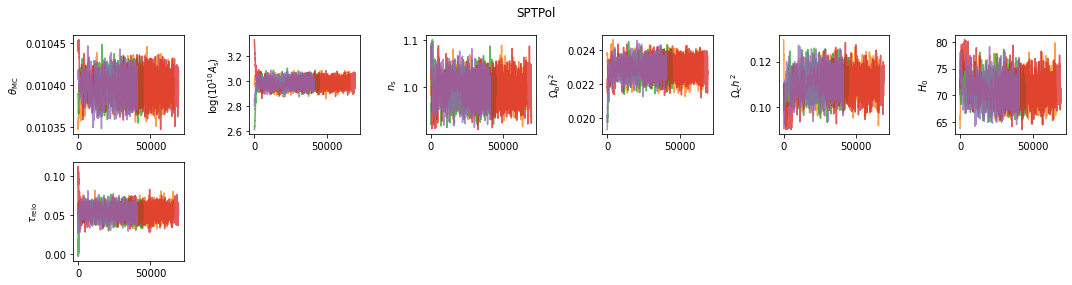

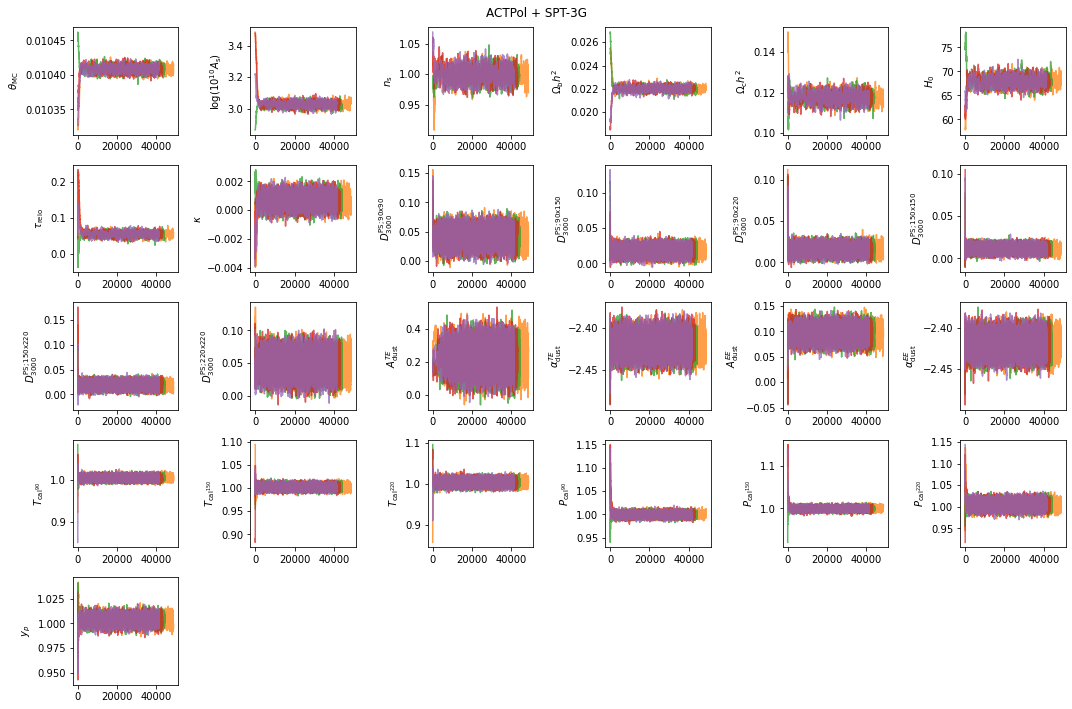

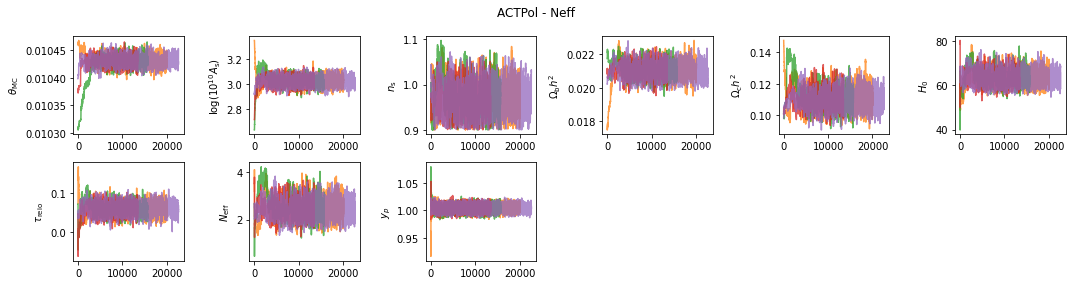

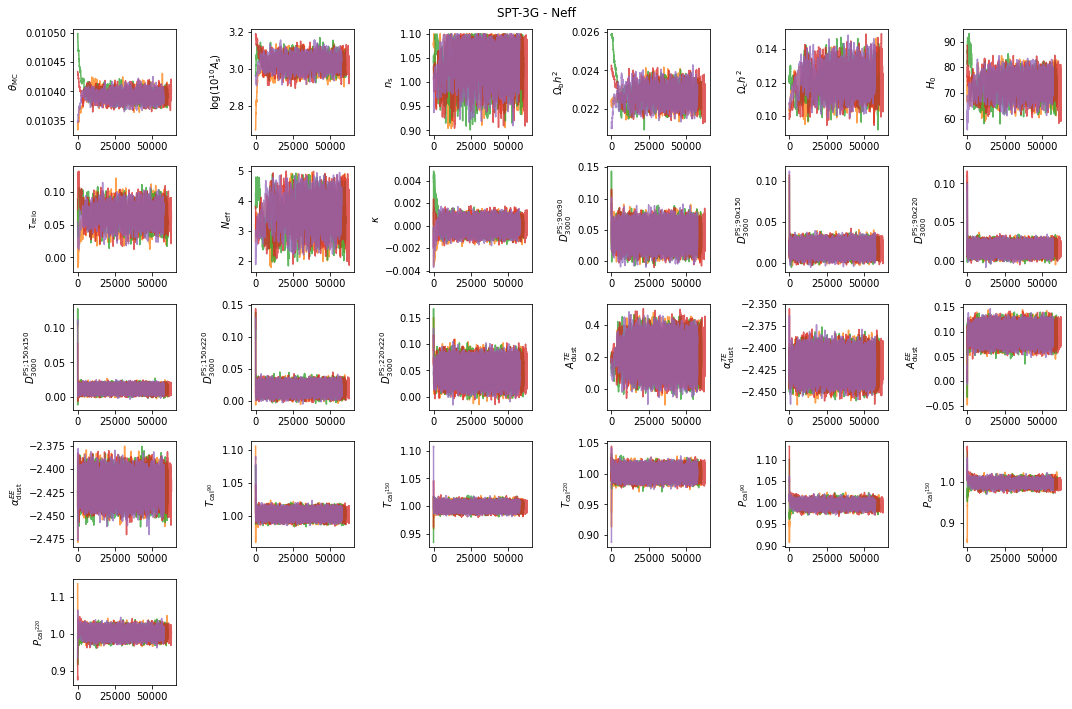

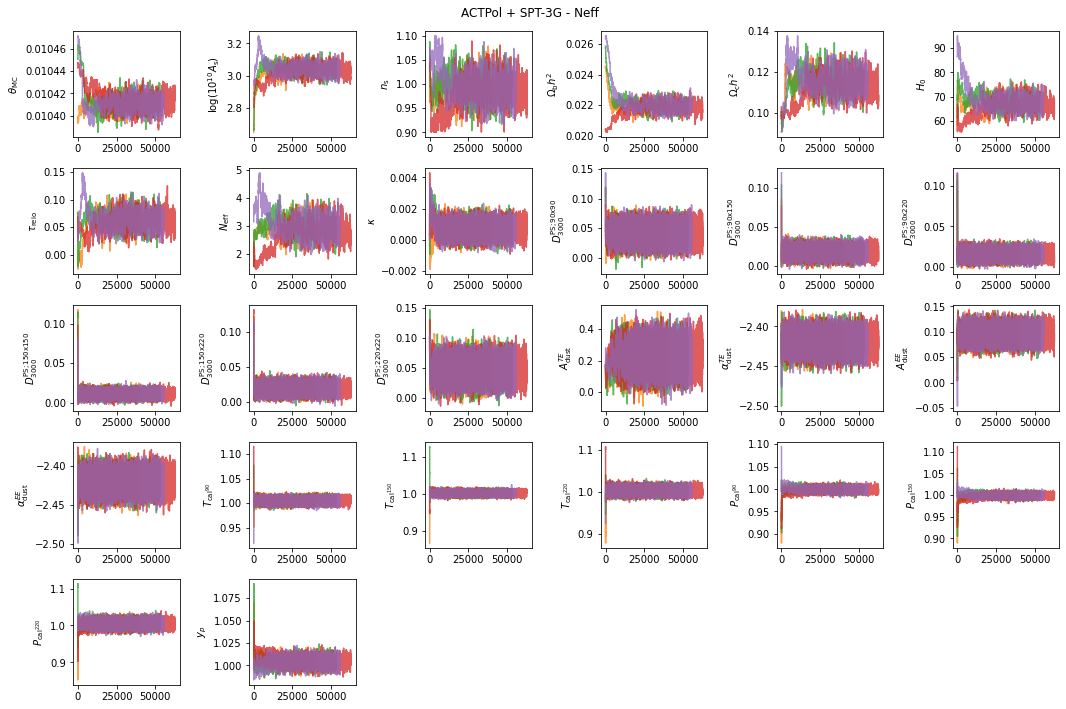

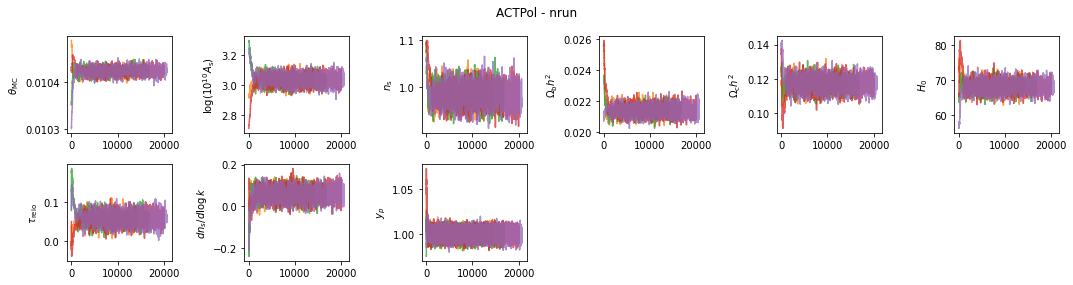

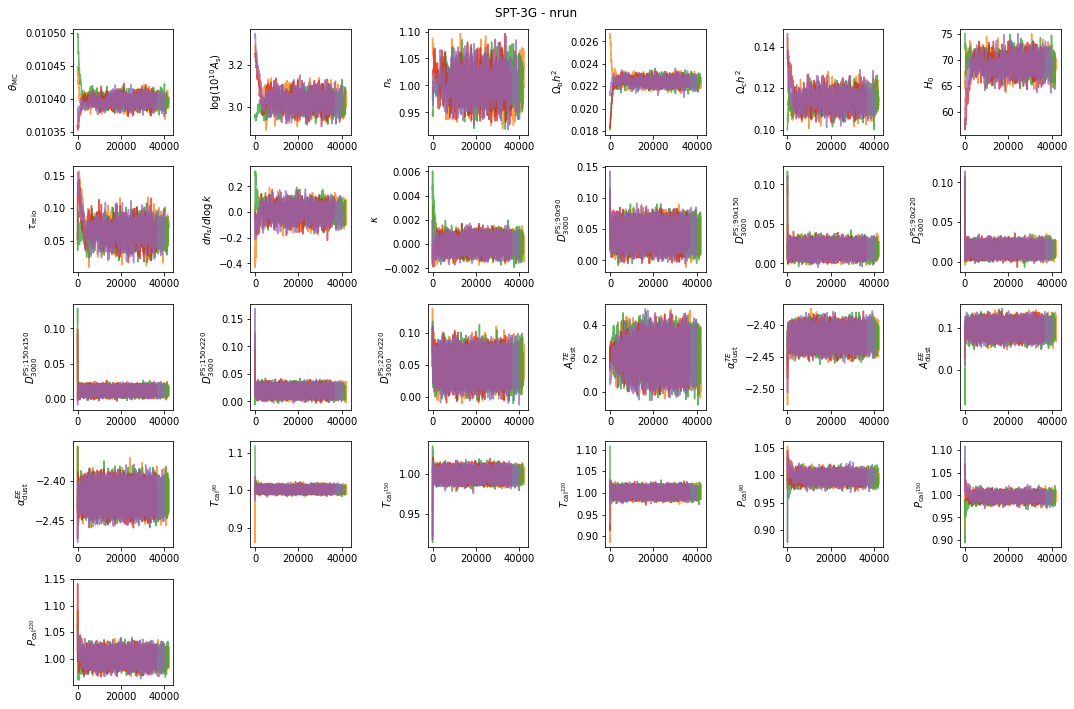

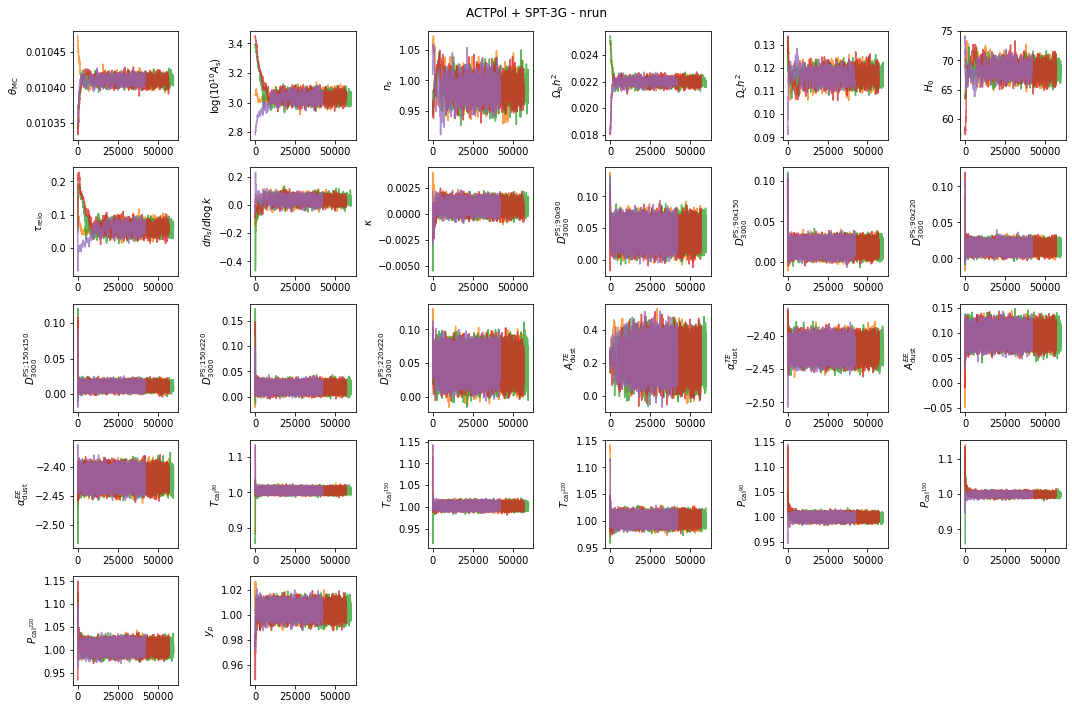

In [7]:
from cobaya_utilities.tools import plot_chains

for k, v in mcmc_samples.items():
    nuisance_params = []
    nuisance_params += ["A_planck"] if "Planck" in k else []
    nuisance_params += spt3g_params if "SPT-3G" in k else []
    nuisance_params += ["yp2"] if "ACTPol" in k else []
    cmb_params = cosmo_params.copy()
    cmb_params += ["nnu"] if "neff" in v else []
    cmb_params += ["nrun"] if "nrun" in v else []
    plot_chains(
        v, params=cmb_params + nuisance_params, title=k, ncol=6, ignore_rows=0.0
    )

Let's plot also the Gelman $R-1$ parameter and acceptance rate progress

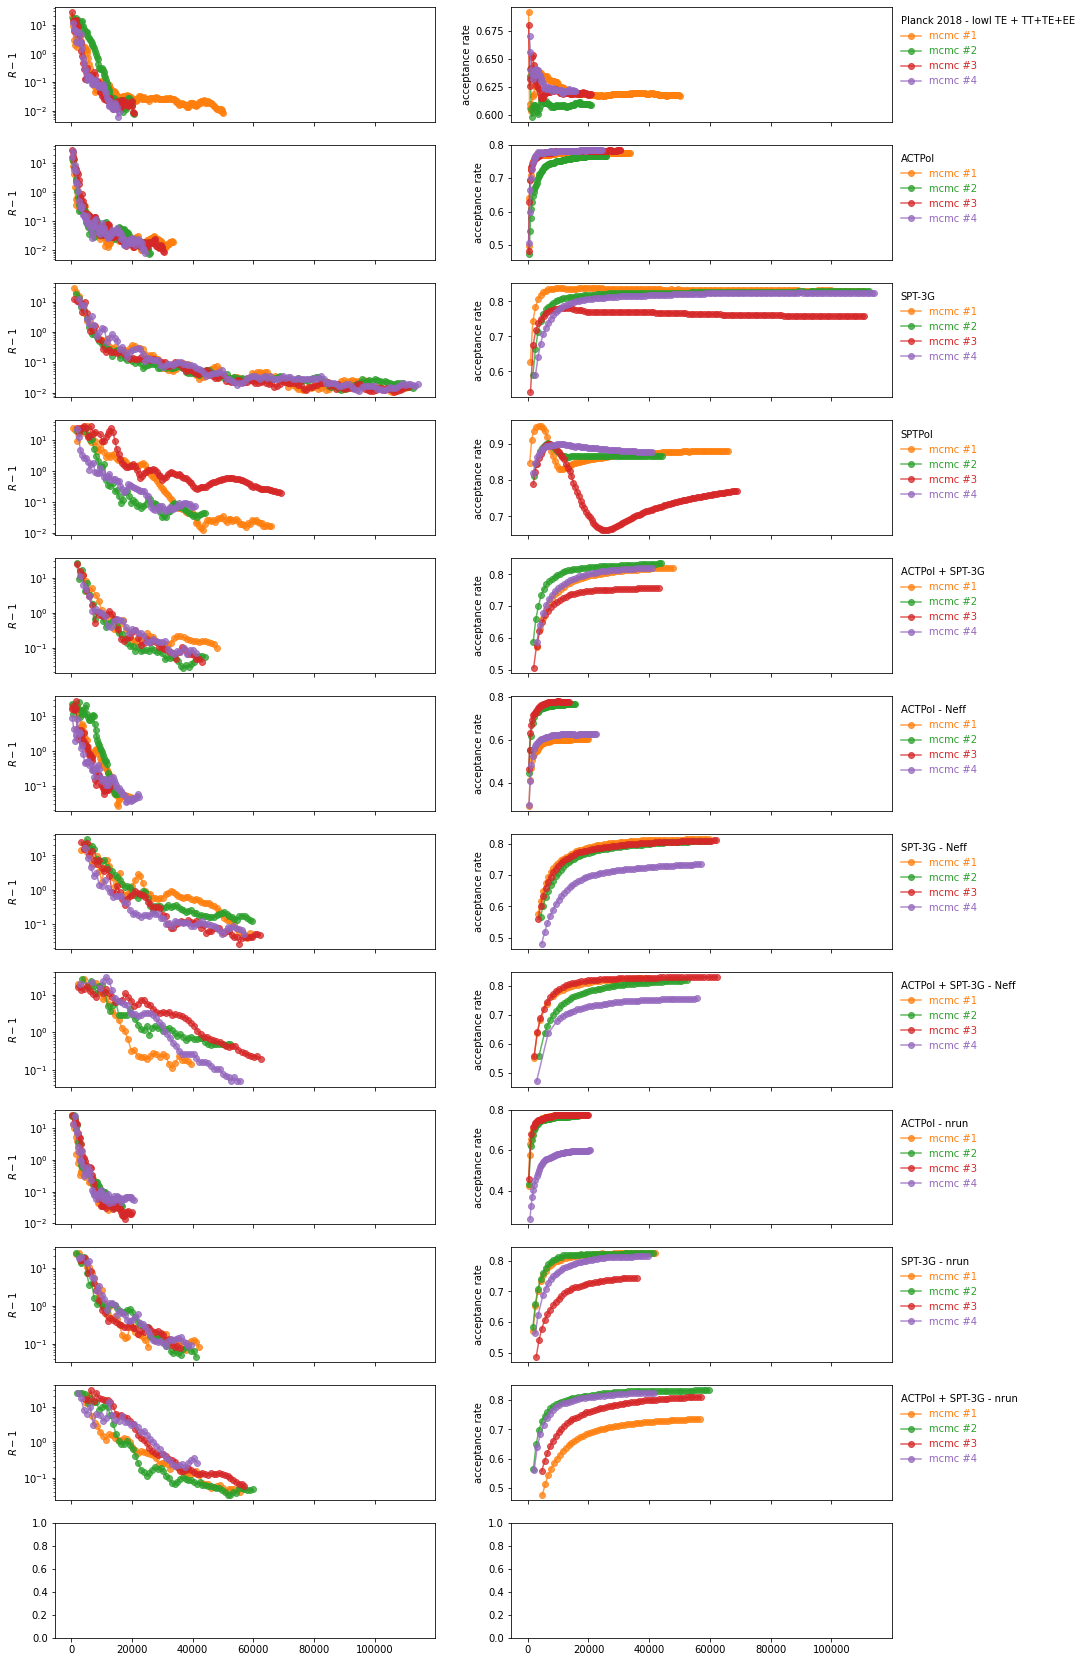

In [8]:
from cobaya_utilities.tools import plot_progress

plot_progress(mcmc_samples)

## MCMC distributions



Define global plot settings

In [9]:
def get_default_settings():
    from getdist.plots import GetDistPlotSettings

    plot_settings = GetDistPlotSettings()
    plot_settings.num_plot_contours = 3
    plot_settings.solid_colors = "tab10"
    plot_settings.line_styles = "tab10"
    plot_settings.linewidth = 2
    plot_settings.legend_fontsize = 15
    plot_settings.legend_colored_text = True
    return plot_settings

Load MCMC samples



In [10]:
from getdist import loadMCSamples

samples = [
    loadMCSamples(os.path.join(path, "mcmc"), settings={"ignore_rows": 0.4})
    for path in mcmc_samples.values()
]

In [11]:
from getdist import plots
from scipy.stats import norm


def get_sample_range(keywords):
    r = re.compile(keywords)
    return [i for i, k in enumerate(mcmc_samples.keys()) if r.match(k)]


def show_inputs(axes, inputs, colors=None):
    for i, ax in enumerate(axes):
        xmin, xmax, ymin, ymax = ax.axis()
        x = np.linspace(xmin, xmax, 100)
        for j, values in enumerate(inputs):
            mean, sigma = values[i]
            if mean is None:
                continue
            y = norm.pdf(x, mean, sigma)
            ax.plot(x, y / np.max(y), color=colors[j], ls="--")


def show_tau_prior(ax, loc=0.054, scale=0.0073):
    show_inputs([ax], inputs=[[(loc, scale)]], colors=["gray"])
    ax.legend([r"$\tau$ prior"], loc="upper left", bbox_to_anchor=(1, 1))

## Comparison SPT-3G/SPTPol with published results

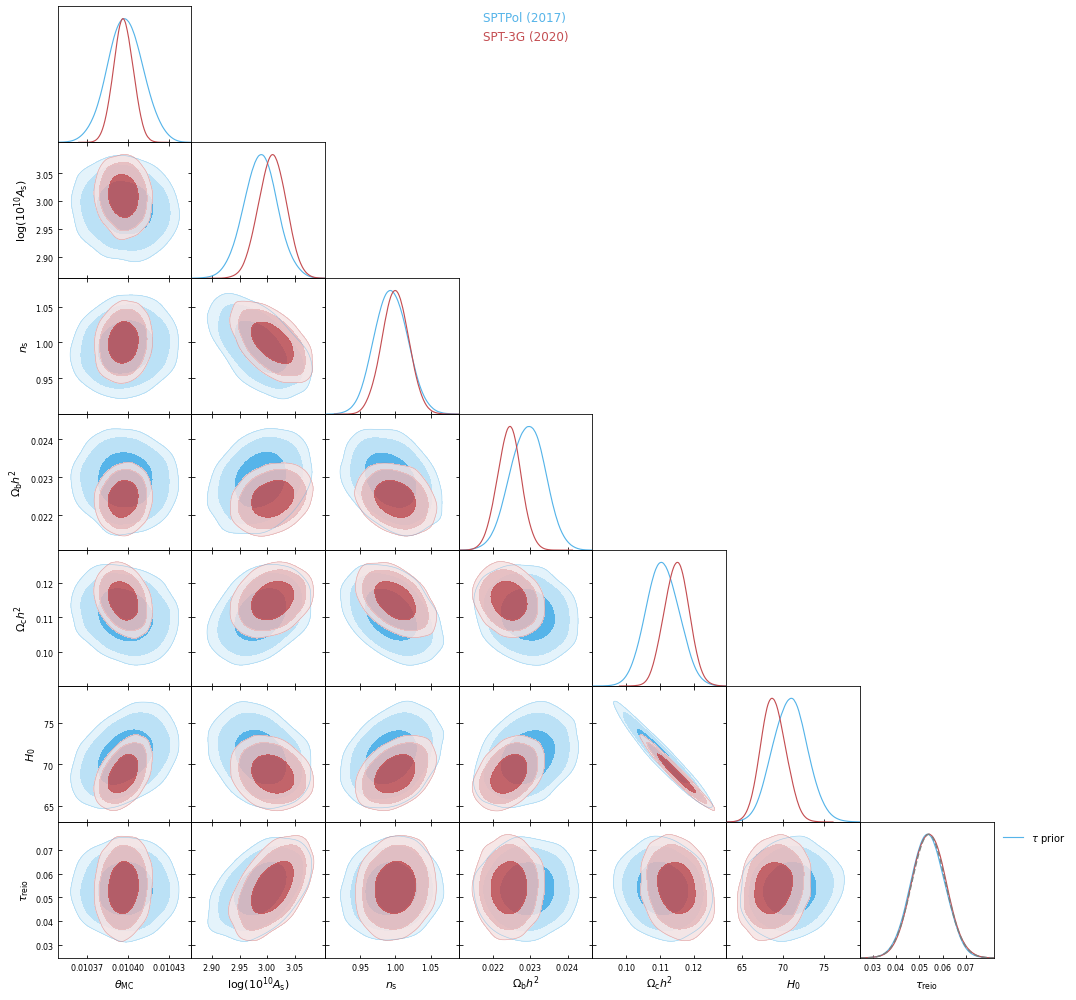

In [15]:
colors = ["#56B4E9", "#C44E52"]
sample_range = get_sample_range("^SPTPol$") + get_sample_range("^SPT-3G$")
labels = ["SPTPol (2017)", "SPT-3G (2020)"]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sample_range],
    cosmo_params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)
show_tau_prior(g.subplots[-1, -1])

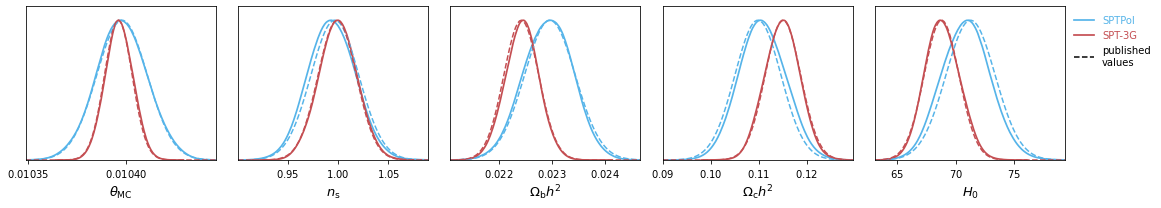

In [14]:
dutcher_results = [
    (1.03961 / 100, 0.00071 / 100),
    (0.999, 0.019),
    (0.02242, 0.00033),
    (0.1150, 0.0037),
    (68.8, 1.5),
]
henning_results = [
    (1.0398 / 100, 0.0013 / 100),
    (0.9967, 0.0238),
    (2.296 / 100, 0.048 / 100),
    (0.1098, 0.0048),
    (71.29, 2.12),
]
params = ["cosmomc_theta", "ns", "ombh2", "omch2", "H0"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=15)
g.plots_1d(
    [samples[i] for i in sample_range],
    params,
    colors=colors,
    nx=len(params),
    legend_labels=[],
)

ax = g.subplots[-1, -1]
ax.plot([], [], "--k")
ax.legend(
    ["SPTPol", "SPT-3G", "published\nvalues"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
)
show_inputs(*g.subplots, inputs=[henning_results, dutcher_results], colors=colors)

## Results

In [16]:
import ipywidgets as widgets


def show_table(sample_range, params):
    labels = [list(mcmc_samples.keys())[i] for i in sample_range]
    ssamples = [samples[i] for i in sample_range]
    return widgets.HBox(
        [
            widgets.VBox(
                [
                    widgets.HTML(
                        f'<p style="font-weight:bold;width:300px;height:75px"><big>{label}</big></p>'
                    ),
                    widgets.Image(
                        value=sample.getTable(limit=1, paramList=params + ["chi2"])
                        .tablePNG(dpi=150, bytesIO=True)
                        .read(),
                        width=300,
                    ),
                ]
            )
            for sample, label in zip(ssamples, labels)
        ]
    )

## ACTPol + SPT3G vs. Planck 2018

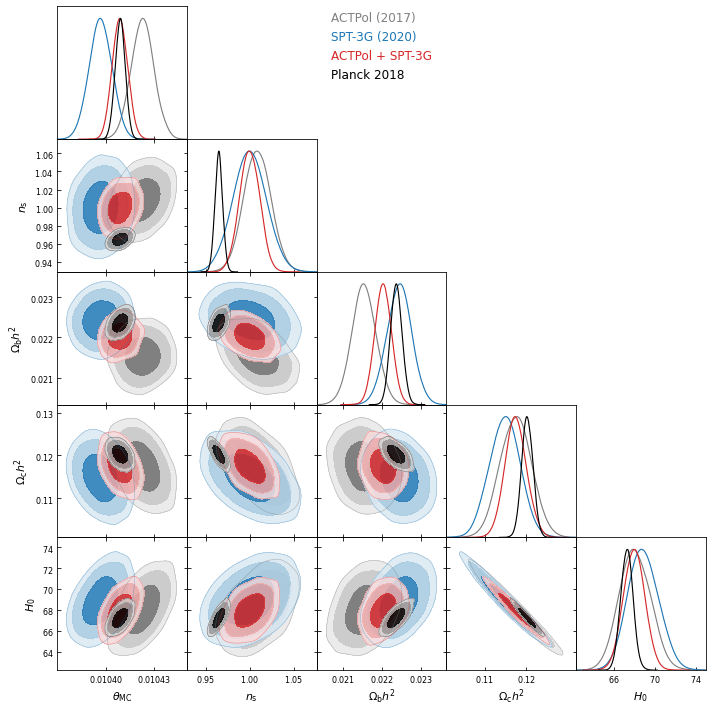

In [17]:
choi_results = [
    (104.221 / 10 ** 4, 0.071 / 10 ** 4),
    (3.046, 0.030),
    (1.006, 0.015),
    (2.145 / 100, 0.031 / 100),
    (11.84 / 100, 0.38 / 100),
    (67.6, 1.5),
    (0.065, 0.015),
]
sr = (
    get_sample_range("ACTPol$")
    + get_sample_range("^SPT-3G$")
    + get_sample_range("ACTPol.*SPT-3G$")
    + get_sample_range("Planck 2018.*lowl TE.*TT\+.*EE$")
)
params = ["cosmomc_theta", "ns", "ombh2", "omch2", "H0"]
labels = ["ACTPol (2017)", "SPT-3G (2020)", "ACTPol + SPT-3G", "Planck 2018"]
colors = ["gray", "tab:blue", "tab:red", "black"]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sr],
    params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

In [18]:
show_table(sample_range=sr, params=cosmo_params)

In [123]:
(0.9998 - 0.9648) / np.sqrt(0.011 ** 2 + 0.0044 ** 2)

2.9542440164531008

In [19]:
0.0037/np.sqrt(2)

0.002616295090390226

In [ ]:
for sample in [samples[i] for i in sr]:
    print(sample.getTable(limit=1, paramList=params + ["chi2"]).tableTex())

## $\Lambda$CDM extensions

### $N_\mathrm{eff}$

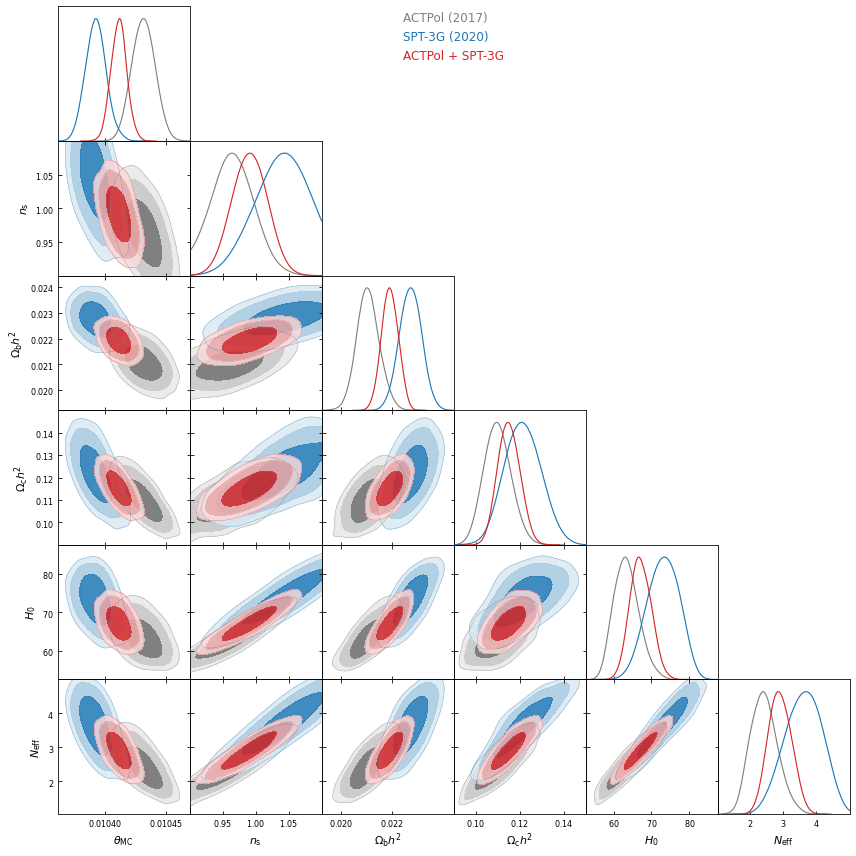

In [26]:
sr = (
    get_sample_range("^ACTPol - Neff$")
    + get_sample_range("^SPT-3G - Neff$")
    + get_sample_range("ACTPol.*SPT-3G.*Neff$")
)
colors = ["gray", "tab:blue", "tab:red"]
params = ["cosmomc_theta", "ns", "ombh2", "omch2", "H0", "nnu"]
labels = ["ACTPol (2017)", "SPT-3G (2020)", "ACTPol + SPT-3G"]#, "Planck 2018"]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sr],
    params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

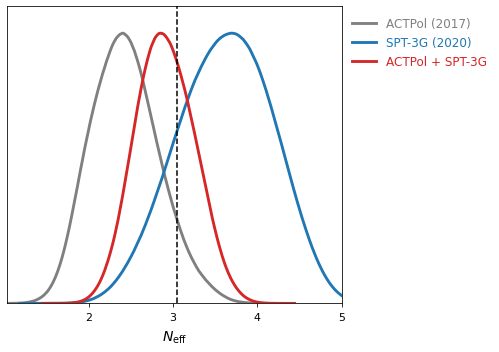

In [27]:
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d(
    [samples[i] for i in sr],
    ["nnu"],
    colors=colors,
    legend_labels=[],
)
ax = g.subplots[-1, -1]
ax.axvline(3.046, c="k", ls="--")
ax.legend(
    labels,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
    fontsize=12,
);

In [28]:
show_table(sample_range=sr, params=cosmo_params + ["nnu"])

### $\frac{dn_s}{d\log k}$

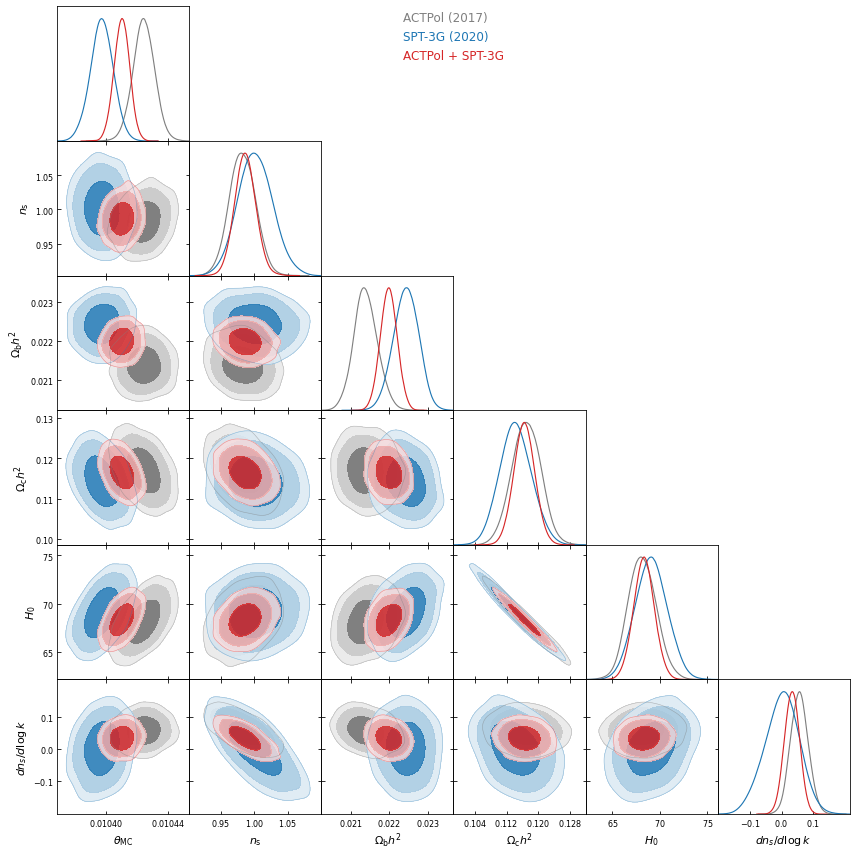

In [21]:
sr = (
    get_sample_range("^ACTPol - nrun$")
    + get_sample_range("^SPT-3G - nrun$")
    + get_sample_range("ACTPol.*SPT-3G.*nrun$")
)
params = ["cosmomc_theta", "ns", "ombh2", "omch2", "H0", "nrun"]
g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sr],
    params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

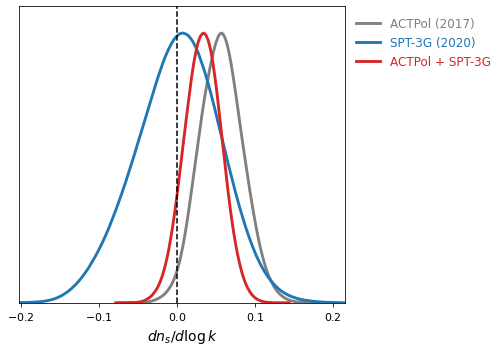

In [22]:
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d(
    [samples[i] for i in sr],
    ["nrun"],
    colors=colors,
    legend_labels=[],
)
ax = g.subplots[-1, -1]
ax.axvline(0, c="k", ls="--")
ax.legend(
    labels,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
    fontsize=12,
);

In [24]:
show_table(sample_range=sr, params=cosmo_params + ["nrun"])